## 3. Preparação dos Dados (Data Preparation)

**Objetivo:** Preparar os dados para análise, o que pode envolver limpeza, transformação e formatação dos dados.

**Resultados:**
- **Dados limpos e pré-processados:** Dados tratados para remover inconsistências, lidar com valores ausentes e normalizar ou transformar variáveis, se necessário.
- **Conjunto de dados pronto para modelagem:** A preparação dos dados inclui a transformação das variáveis de forma a torná-las adequadas para o modelo de análise, como normalização, agregação e criação de novas variáveis, se necessário.
- **Redução de dimensionalidade (se necessário):** Caso a quantidade de dados seja grande, a redução de variáveis irrelevantes pode ser realizada.

In [80]:
import pandas as pd
import numpy as np
import os
import zipfile
import geopandas as gpd
from shapely.geometry import Point

### Ano de interesse

In [93]:
year = 2008

### Definição de funções

In [81]:
# Função para calcular a distância usando a fórmula de Haversine em vetor
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Raio da Terra em quilômetros
    R = 6371.0
    
    # Converter as latitudes e longitudes de graus para radianos
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Diferença de latitudes e longitudes
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    # Fórmula de Haversine em vetor
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(delta_lon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distância em quilômetros
    distance = R * c
    return distance

### Pega LAT e LON da estações INMET

In [82]:
# # Base directory containing subdirectories with .zip files
# base_dir = '../data/raw/INMET'
# unzip_root = os.path.join(base_dir, 'unzip')
# os.makedirs(unzip_root, exist_ok=True)

# # Recursively find all .zip files
# zip_files = []
# for root, dirs, files in os.walk(base_dir):
#     for file in files:
#         if file.endswith('.zip'):
#             zip_files.append(os.path.join(root, file))

# # Loop over each zip file
# for zip_file_path in zip_files:
#     zip_name = os.path.splitext(os.path.basename(zip_file_path))[0]
#     unzip_path = os.path.join(unzip_root, zip_name)
#     os.makedirs(unzip_path, exist_ok=True)

#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:       
#         filtered_files = [file for file in zip_ref.namelist()]

#         for member in filtered_files:
#             filename = os.path.basename(member)
#             if not filename:
#                 continue  # skip folders
#             target_path = os.path.join(unzip_path, filename)
#             with zip_ref.open(member) as source, open(target_path, 'wb') as target:
#                 target.write(source.read())

#     print(f"Unzipped {len(filtered_files)} files from {zip_file_path} to {unzip_path}")

In [94]:
import os
import pandas as pd

# Define the folder path containing the files
folder_path = f'../data/raw/inmet/unzip/{year}'  # Replace with your folder path

# Get a list of all CSV files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.CSV')]  # Adjust file extension if needed

# List to store DataFrames
dataframes = []

# Loop through each file in the list
for file in file_list:
    file_path = os.path.join(folder_path, file)  # Get full file path
    
    try:
        # Read the first 7 rows (adjust this if more rows are needed)
        df0 = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1', skiprows=0, decimal=',', nrows=7)

        # Create a new dictionary to store station info
        df_station = {}

        # Extract station information and handle errors if necessary
        df_station['REGIAO'] = df0.iloc[0, 1] if len(df0) > 1 else None
        df_station['ESTACAO'] = df0.iloc[1, 1] if len(df0) > 1 else None
        df_station['CODIGO(WMO)'] = df0.iloc[2, 1] if len(df0) > 2 else None
        df_station['LATITUDE'] = float(df0.iloc[3, 1].replace(',', '.')) if len(df0) > 3 and df0.iloc[3, 1] else None
        df_station['LONGITUDE'] = float(df0.iloc[4, 1].replace(',', '.')) if len(df0) > 4 and df0.iloc[4, 1] else None
        df_station['ALTITUDE'] = float(df0.iloc[5, 1].replace(',', '.')) if len(df0) > 5 and df0.iloc[5, 1] else None
        df_station['DATAFUNDACAO'] = df0.iloc[6, 1] if len(df0) > 6 else None

        # Convert to DataFrame and append to the list
        df_stations = pd.DataFrame([df_station])
        dataframes.append(df_stations)

    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Combine all DataFrames into a single DataFrame
df_stations_final = pd.concat(dataframes, ignore_index=True)

# Display the first few rows
df_stations_final.head()


,REGIAO,ESTACAO,CODIGO(WMO),LATITUDE,LONGITUDE,ALTITUDE,DATAFUNDACAO
0,PA,TOME ACU,A213,-2.600000,-48.366667,38.00,2007-10-14
1,SC,NOVO HORIZONTE,A816,-26.406944,-52.850556,960.00,2008-09-20
2,SC,INDAIAL,A817,-26.913611,-49.267500,86.13,2006-07-02
3,SC,JOACABA,A841,-27.169444,-51.575556,776.00,2007-09-20
4,SC,BOM JARDIM DA SERRA - MORRO DA IGREJA,A845,-28.133333,-49.483333,1810.00,2007-06-17


### Dados de entrada dos municípios

In [95]:
shape = gpd.read_file('../data/raw/shapefiles/SP.shp')

shapeM = gpd.read_file('../data/raw/shapefiles/SP_Municipios_2022.shp')
LON = shapeM['xcentroide'].values
LAT = shapeM['ycentroide'].values
points_centroids = list()
for j in range(len(LON)):
    point_centroids = Point(LON[j], LAT[j])
    points_centroids.append(point_centroids)
    gdf_centroids = gpd.GeoDataFrame(geometry=points_centroids).set_crs(shapeM.crs)

### Gera a matriz de distancia entre as estações

In [96]:
# Número de estacoes
n_stations = len(df_stations_final) 
n_municipios = len(LAT)

# Extrair latitudes e longitudes do DataFrame
latitudes  = df_stations_final['LATITUDE'].values
longitudes = df_stations_final['LONGITUDE'].values

# Criar uma matriz de distâncias x5 usando broadcasting
distances = np.zeros((n_municipios, n_stations))


# Usando broadcasting para calcular todas as distâncias
for i in range( n_municipios ):
    distances[i] = haversine_vectorized(LAT[i], LON[i], latitudes, longitudes)

# Precomputando 1/distances
inv_distances = 1 / distances

# np.fill_diagonal(inv_distances, 0.0)

# Exibir a matriz de distâncias
distance_df = pd.DataFrame(distances, columns=df_stations_final['CODIGO(WMO)'], index=shapeM['CD_MUN'])

distance_df.head(2)

CODIGO(WMO),A213,A816,A817,A841,A845,A848,A851,A857,A858,A859,...,A608,A001,A045,A002,A003,A011,A012,A013,A014,A015
CD_MUN,,,,,,,,,,,,,,,,,,,,,
3500105,2130.489598,566.688389,620.258883,623.704744,745.828094,584.962119,557.634840,628.744834,611.460818,582.648508,...,957.114371,723.494429,757.314468,582.010360,476.075140,294.244884,673.877955,643.122670,634.637167,751.186342
3500204,2082.870033,655.415748,626.519560,682.258130,761.129798,687.535797,542.542563,724.732533,687.859243,629.605407,...,817.513692,638.045281,668.098253,518.720697,401.494889,277.352856,585.403230,658.092619,597.232356,701.706227


In [97]:
distance_df_filtered = distance_df.loc[:, distance_df.min() <= 280]
distance_df_filtered.head()

CODIGO(WMO),A817,A851,A861,A862,A502,A505,A507,A509,A510,A512,...,A823,A754,A601,A602,A603,A604,A606,A608,A003,A011
CD_MUN,,,,,,,,,,,,,,,,,,,,,
3500105,620.258883,557.634840,602.875232,540.450729,755.956617,480.870776,416.221265,535.658330,854.592530,333.126495,...,443.214597,410.738857,771.422704,784.499817,809.118843,941.890536,943.309609,957.114371,476.075140,294.244884
3500204,626.519560,542.542563,629.988338,551.417639,609.651295,337.993437,301.345856,410.644628,706.716641,260.214683,...,497.601024,553.000625,637.403279,652.934292,672.430331,797.528531,808.331933,817.513692,401.494889,277.352856
3500303,585.864210,476.806907,627.738889,533.254050,350.391486,271.972669,370.639018,136.491154,455.381441,430.779155,...,567.848666,828.981455,354.944813,370.338640,391.159215,528.191072,526.289657,538.937628,527.771624,506.212146
3500402,614.486803,504.376055,659.425241,564.607774,311.604984,257.658324,370.611124,124.947363,416.291736,441.999089,...,604.697543,863.230232,324.641688,341.842087,358.754739,491.047846,494.857609,504.638873,530.034450,523.879175
3500501,562.766550,451.704077,612.375620,517.333799,323.312656,320.569111,430.939118,71.808606,430.324469,495.445606,...,571.246549,880.344742,301.573318,314.290636,341.016923,489.730122,473.505785,491.728953,589.458709,571.121271


In [98]:

# Ensure that 'CODIGO(WMO)' exists as a column in df_stations_final
filtered_df_stations = df_stations_final[df_stations_final['CODIGO(WMO)'].isin(distance_df_filtered.columns)]
filtered_df_stations


,REGIAO,ESTACAO,CODIGO(WMO),LATITUDE,LONGITUDE,ALTITUDE,DATAFUNDACAO
2,SC,INDAIAL,A817,-26.913611,-49.267500,86.13,2006-07-02
6,SC,ITAPOA,A851,-26.081111,-48.641667,2.00,2007-06-06
11,SC,RIO DO CAMPO,A861,-26.937500,-50.146389,592.00,2008-03-10
12,SC,RIO NEGRINHO,A862,-26.248611,-49.580556,869.00,2008-03-22
37,MG,BARBACENA,A502,-21.228889,-43.766944,1155.00,2002-12-05
...,...,...,...,...,...,...,...
404,RJ,CAMBUCI,A604,-21.566667,-41.950000,35.00,2002-11-20
405,RJ,ARRAIAL DO CABO,A606,-22.983333,-42.016667,4.00,2006-09-24
407,RJ,MACAE,A608,-22.383333,-41.816667,32.00,2006-09-22
411,GO,MORRINHOS,A003,-17.716667,-49.100000,771.42,2001-05-25


In [100]:
LAT_E = filtered_df_stations['LATITUDE'].values
LON_E = filtered_df_stations['LONGITUDE'].values
points_estacoes = list()
for j in range(len(LON_E)):
    point_estacoes = Point(LON_E[j], LAT_E[j])
    points_estacoes.append(point_estacoes)
    gdf_filtered_stations = gpd.GeoDataFrame(geometry=points_estacoes).set_crs(shapeM.crs)

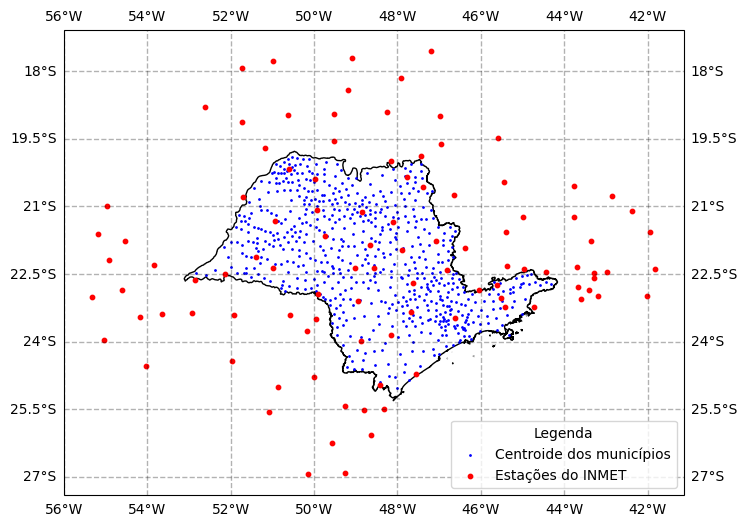

In [101]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import cartopy
import cartopy.crs as ccrs

shape = gpd.read_file('../data/raw/shapefiles/SP.shp')

shapeM = gpd.read_file('../data/raw/shapefiles/SP_Municipios_2022.shp')
LON = shapeM['xcentroide'].values
LAT = shapeM['ycentroide'].values
points_centroids = list()
for j in range(len(LON)):
    point_centroids = Point(LON[j], LAT[j])
    points_centroids.append(point_centroids)
    gdf_centroids = gpd.GeoDataFrame(geometry=points_centroids).set_crs(shapeM.crs)

  
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(8, 8))
shape.plot(ax=ax, facecolor='white', edgecolor='black')
# shapeM.plot(ax=ax, column="AREA_KM2")
gl = ax.gridlines(draw_labels=True,linewidth=1, color='black', alpha=0.3, linestyle='--')
gdf_centroids.plot(ax=ax, color='b', markersize=1, legend=True, label= 'Centroide dos municípios')
gdf_filtered_stations.plot(ax=ax, color='r', markersize=10, legend=True, label= 'Estações do INMET')
plt.legend(title='Legenda', loc='lower right', fontsize=10)

# plt.savefig(f'Estações_SP.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()  

## Leitura dos dados das Estações Filtradas

In [ ]:
# Define the folder path containing the files
folder_path = f'../data/raw/inmet/unzip/{year}'  # Replace with your folder path

# Get a list of all CSV files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.CSV')]  # Adjust file extension if needed

# List to store filtered files
filtered_files = [file for file in file_list if any(codigo in file for codigo in filtered_df_stations['CODIGO(WMO)'])]

# List to store DataFrames
dataframes = []

# Loop through each file in the list
for file in filtered_files:
     file_path = os.path.join(folder_path, file)  # Get full file path
     df1 = pd.read_csv(file_path, sep=';', encoding = 'ISO-8859-1', skiprows=8, decimal=',')
     df2 = pd.read_csv(file_path, sep=';', encoding = 'ISO-8859-1', skiprows=0, decimal=',', nrows=7)
     for k in range(7):
        #  df1['UF'] = df2.iloc[0, 1]
         df1['ESTACAO'] = df2.iloc[1, 1]
         df1['CODIGO (WMO)'] = df2.iloc[2, 1]

     dataframes.append(df1) 

df = pd.concat(dataframes, ignore_index=True)
df.drop('Unnamed: 19', axis=1, inplace=True)

df['Hora UTC'] = df['Data'] + ' ' + df['Hora UTC']

df['Data'] = pd.to_datetime(df['Data'])
df['ANO']  = df['Data'].dt.year
df['MES']  = df['Data'].dt.month
df['HORA'] = pd.to_datetime(df['Hora UTC']).dt.hour

df['CODIGO (WMO)'] = df['CODIGO (WMO)'].astype("string")


df['Hora UTC'] = pd.to_datetime(df['Hora UTC'])

df['DIA'] = df['Data'].dt.day 
      
cols= {'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)' : 'CHUVA',
        'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)' : 'PRE_INS',
        'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)' : 'PRE_MAX',
        'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)' : 'PRE_MIN',
        'RADIACAO GLOBAL (KJ/m²)' : 'RAD_GLO',
        'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)' : 'TEM_INS',
        'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)' : 'TEM_MAX',
        'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)' : 'TEM_MIN',
        'TEMPERATURA DO PONTO DE ORVALHO (°C)' : 'PTO_INS',
        'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)' : 'PTO_MAX',
        'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)' : 'PTO_MIN',
        'UMIDADE RELATIVA DO AR, HORARIA (%)' : 'UMD_INS',
        'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)' : 'UMD_MAX',
        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)' : 'UMD_MIN',
        'VENTO, DIREÇÃO HORARIA (gr) (° (gr))' : 'VEN_DIR',
        'VENTO, RAJADA MAXIMA (m/s)' : 'VEN_RAJ',
        'VENTO, VELOCIDADE HORARIA (m/s)' : 'VEN_VEL',
        'CODIGO (WMO)':'COD(WMO)'}

        # 'LATITUDE' : 'LAT',	'LONGITUDE' : 'LON',	
        # 'ALTITUDE' : 'ALT', 

df = df.rename(columns=cols, errors="raise")
df.head(3)

In [113]:
df['CODIGO (WMO)'].unique()

array(['A817', 'A851', 'A861', 'A862', 'A502', 'A505', 'A507', 'A509',
       'A510', 'A512', 'A513', 'A514', 'A515', 'A516', 'A517', 'A518',
       'A519', 'A520', 'A523', 'A609', 'A711', 'A729', 'A746', 'A824',
       'A610', 'A611', 'A618', 'A619', 'A621', 'A652', 'A701', 'A705',
       'A706', 'A707', 'A708', 'A835', 'A842', 'A847', 'A849', 'A850',
       'A869', 'A871', 'A873', 'A025', 'A034', 'A035', 'A524', 'A525',
       'A529', 'A530', 'A531', 'A712', 'A713', 'A714', 'A715', 'A716',
       'A718', 'A725', 'A726', 'A727', 'A728', 'A704', 'A709', 'A710',
       'A721', 'A536', 'A016', 'A752', 'A733', 'A734', 'A735', 'A736',
       'A737', 'A738', 'A739', 'A740', 'A741', 'A730', 'A731', 'A742',
       'A743', 'A749', 'A750', 'A751', 'A546', 'A747', 'A753', 'A807',
       'A818', 'A819', 'A820', 'A821', 'A822', 'A823', 'A754', 'A601',
       'A602', 'A603', 'A604', 'A606', 'A608', 'A003', 'A011'],
      dtype=object)

In [115]:
# Define the folder path containing the files
folder_path = f'../data/raw/inmet/unzip/{year}'  # Replace with your folder path

# Get a list of all CSV files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.CSV')]  # Adjust file extension if needed

# List to store filtered files
filtered_files = [file for file in file_list if any(codigo in file for codigo in filtered_df_stations['CODIGO(WMO)'])]

# List to store DataFrames
dataframes = []

# Process each filtered file
for file in filtered_files:
    file_path = os.path.join(folder_path, file)  # Get full file path
    df1 = pd.read_csv(file_path, sep=';', encoding = 'ISO-8859-1', skiprows=8, decimal=',')
    df2 = pd.read_csv(file_path, sep=';', encoding = 'ISO-8859-1', skiprows=0, decimal=',', nrows=7)
    for k in range(7):
        #  df1['UF'] = df2.iloc[0, 1]
        df1['ESTACAO'] = df2.iloc[1, 1]
        df1['CODIGO (WMO)'] = df2.iloc[2, 1]

    dataframes.append(df1) 

df = pd.concat(dataframes, ignore_index=True)
df.drop('Unnamed: 19', axis=1, inplace=True)

df.rename(columns={df.columns[0]: 'Data', df.columns[1]: 'Hora UTC'}, inplace=True)

df['Hora UTC'] = df['Data'] + ' ' + df['Hora UTC']

df['Data'] = pd.to_datetime(df['Data'])
df['ANO']  = df['Data'].dt.year
df['MES']  = df['Data'].dt.month
df['HORA'] = pd.to_datetime(df['Hora UTC']).dt.hour

# Criar uma coluna com o mês e o ano para facilitar o agrupamento
df['ANO_MES'] = df['Data'].dt.to_period('M')

df['CODIGO (WMO)'] = df['CODIGO (WMO)'].astype("string")


df['Hora UTC'] = pd.to_datetime(df['Hora UTC'])
# df['DATA DE FUNDACAO'] = pd.to_datetime(df['DATA DE FUNDACAO'], format='mixed')

df['DIA'] = df['Data'].dt.day

df.columns = df.columns.str.upper()
    
cols = {'PRECIPITAÇÃO TOTAL, HORÁRIO (MM)' : 'CHUVA', 
        'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (MB)' : 'PRE_INS',
        'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (MB)' : 'PRE_MAX',
        'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (MB)' : 'PRE_MIN',
        'RADIACAO GLOBAL (KJ/M²)' : 'RAD_GLO',
        'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)' : 'TEM_INS',
        'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)' : 'TEM_MAX',
        'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)' : 'TEM_MIN',
        'TEMPERATURA DO PONTO DE ORVALHO (°C)' : 'PTO_INS',
        'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)' : 'PTO_MAX',
        'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)' : 'PTO_MIN',
        'UMIDADE RELATIVA DO AR, HORARIA (%)' : 'UMD_INS',
        'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)' : 'UMD_MAX',
        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)' : 'UMD_MIN',
        'VENTO, DIREÇÃO HORARIA (GR) (° (GR))' : 'VEN_DIR',
        'VENTO, RAJADA MAXIMA (M/S)' : 'VEN_RAJ',
        'VENTO, VELOCIDADE HORARIA (M/S)' : 'VEN_VEL',
        'CODIGO (WMO)':'COD(WMO)'}

df = df.rename(columns=cols, errors="raise")        

print(f"The number of -9999 were: {(df == -9999).sum().sum()}")
df.replace(-9999, np.nan, inplace=True)

df.head()

The number of -9999 were: 1220818


,DATA,HORA UTC,CHUVA,PRE_INS,PRE_MAX,PRE_MIN,RAD_GLO,TEM_INS,PTO_INS,TEM_MAX,...,VEN_DIR,VEN_RAJ,VEN_VEL,ESTACAO,COD(WMO),ANO,MES,HORA,ANO_MES,DIA
0,2008-01-01,2008-01-01 00:00:00,0.0,1003.8,1003.8,1003.5,NaN,21.9,20.7,23.1,...,238.0,3.1,1.5,INDAIAL,A817,2008,1,0,2008-01,1
1,2008-01-01,2008-01-01 01:00:00,0.0,1004.5,1004.6,1003.8,NaN,21.5,20.2,21.9,...,215.0,4.9,2.6,INDAIAL,A817,2008,1,1,2008-01,1
2,2008-01-01,2008-01-01 02:00:00,0.0,1004.4,1004.5,1004.1,NaN,21.5,19.8,21.9,...,175.0,6.5,1.5,INDAIAL,A817,2008,1,2,2008-01,1
3,2008-01-01,2008-01-01 03:00:00,0.0,1004.7,1004.8,1004.4,NaN,21.1,19.9,21.5,...,198.0,3.3,0.3,INDAIAL,A817,2008,1,3,2008-01,1
4,2008-01-01,2008-01-01 04:00:00,0.0,1003.7,1004.7,1003.7,NaN,20.7,19.5,21.1,...,203.0,3.5,1.9,INDAIAL,A817,2008,1,4,2008-01,1


### Interpolações

In [125]:
### Gera a matriz de distancia entre as estações
def distance_matrix(df_estacoes, shapeM, LAT, LON):
    # Número de estacoes
    n_estacoes = len(df_estacoes) 
    n_municipios = len(LAT)

    # Extrair latitudes e longitudes do DataFrame
    latitudes  = df_estacoes['LAT'].values
    longitudes = df_estacoes['LON'].values

    # Criar uma matriz de distâncias x5 usando broadcasting
    distances = np.zeros((n_municipios, n_estacoes))


    # Usando broadcasting para calcular todas as distâncias
    for i in range( n_municipios ):
        distances[i] = haversine_vectorized(LAT[i], LON[i], latitudes, longitudes)

    # Precomputando 1/distances
    # inv_distances = 1 / distances

    # np.fill_diagonal(inv_distances, 0.0)

    # Exibir a matriz de distâncias
    distance_df = pd.DataFrame(distances, columns=df_estacoes['COD(WMO)'], index=shapeM['CD_MUN'])

    distance_df.head(2)
    
    return distance_df



# Função para calcular a distância usando a fórmula de Haversine em vetor
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Raio da Terra em quilômetros
    R = 6371.0
    
    # Converter as latitudes e longitudes de graus para radianos
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Diferença de latitudes e longitudes
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    # Fórmula de Haversine em vetor
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(delta_lon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distância em quilômetros
    distance = R * c
    return distance


def idw_interpolation_precomputed_single(distances, known_values, alpha):
    """
    Performs IDW interpolation for a single point using precomputed inverse distances.
    
    Parameters:
    - distances: A numpy array of inverse distances to the known stations.
    - known_values: A numpy array of values at the known stations.
    - alpha: The exponent for the IDW interpolation.
    
    Returns:
    - The interpolated value at the target point.
    """
    # # Compute the weights based on the inverse distance formula
    # weights = 1 / (distances ** alpha)
    
    # # Calculate the weighted sum of known values and divide by the sum of the weights
    # interpolated_value = (weights * known_values).sum() / weights.sum()
    
    
    # Mask for valid known_values (i.e., not NaN)
    valid_mask = ~np.isnan(known_values)

    # Filter distances and values using the same mask
    valid_distances = distances[valid_mask]
    valid_values = known_values[valid_mask]

    # Avoid division by zero
    if len(valid_values) == 0:
        interpolated_value = np.nan  # or handle however you prefer
    else:
        weights = 1 / (valid_distances ** alpha)
        interpolated_value = (weights * valid_values).sum() / weights.sum()
    
    return interpolated_value



def perform_idw_interpolation_municipios(df: pd.DataFrame, df_e: pd.DataFrame, variables_to_interpolate: list, variables_to_interpolate_int: list, distance_df: pd.DataFrame, alpha, max_distance):
    """
    Interpolates missing values in the specified columns using Inverse Distance Weighting (IDW), 
    considering only distances smaller than a user-defined threshold.

    Parameters:
    - df: DataFrame containing the data with missing values to interpolate.
    - variables_to_interpolate: List of column names that contain missing values to interpolate.
    - distance_df: DataFrame containing precomputed inverse distances between stations.
    - alpha: The exponent for the IDW interpolation.
    - max_distance: The maximum distance threshold for considering stations in the interpolation.

    Returns:
    - The DataFrame with missing values interpolated.
    """
    
    # Get unique station and date information
    unique_municipios = distance_df.index
    unique_stations = df_e['COD(WMO)'].unique()
    
    # Get unique hours for the current date
    unique_date_hours = df['HORA UTC'].unique()
    
    dfind = 0
    for hour in unique_date_hours:
        # Filter DataFrame for the current date and hour
        df_for_date_and_hour = df_e[df_e['HORA UTC'] == hour]
        

        
        # Loop through stations with missing values
        for idx, target_municipio_code in enumerate(unique_municipios):                    

            # Get precomputed inverse distances for interpolation
            distances = distance_df.loc[target_municipio_code].T.loc[ df_for_date_and_hour['COD(WMO)'].values ].values
            
            # Filter out distances greater than the max_distance threshold
            valid_distances0 = distances < max_distance           
            valid_distances = distances[valid_distances0]
    
            for ivx, variable in enumerate(variables_to_interpolate):
                                
                known_values = df_for_date_and_hour[variable].values                               
                valid_known_values = known_values[valid_distances0]
                # print(valid_distances)
                # print(valid_known_values)                
                # Skip interpolation if no valid distances are available
                # Perform IDW interpolation for the missing value
                interpolated_value = idw_interpolation_precomputed_single(valid_distances, valid_known_values, alpha)
                
                # Update the missing value in the original DataFrame
                df.loc[df.index[dfind], variables_to_interpolate_int[ivx]] = interpolated_value
            df.loc[df.index[dfind], 'CD_MUN'] = str(target_municipio_code)
            df.loc[df.index[dfind], 'HORA UTC'] = hour
            dfind += 1
        print(idx, hour, variables_to_interpolate_int[ivx], interpolated_value)    

    return df

In [126]:
def interpolate_dataset(processed_dir, ANO):
    
    variables_to_interpolate = ['TEM_INS', 'TEM_MAX', 'TEM_MIN',
                                'UMD_INS', 'UMD_MAX', 'UMD_MIN',
                                'CHUVA',
                                'VEN_RAJ', 'VEN_VEL']
    
    n_municipios = len(LAT)

    df_estacoes =filtered_df_stations    
    df_estacoes.columns = df_estacoes.columns.str.upper()
    
    distance_df = distance_df_filtered

    # Valores únicos da coluna 'Hora UTC'
    horas_unicas = df['HORA UTC'].unique()
        
    # Variables to interpolate (columns with NaN values)
    # variables_to_interpolate_int = [var + '_INT' for var in variables_to_interpolate]
    
    # # Create a new list by adding '_INT' to each item
    variables_to_interpolate_int = variables_to_interpolate

    dfs = []  # Lista para armazenar os DataFrames temporários
    for i in range(n_municipios):
        df_municipios0 = pd.DataFrame({'HORA UTC': horas_unicas})
        df_municipios0['CD_MUN'] = '0'

        for var in variables_to_interpolate:
            df_municipios0[var] = 0.0

        dfs.append(df_municipios0)

    # Agora concatena tudo de uma vez só
    df_municipios_final = pd.concat(dfs, ignore_index=True)
    # df_municipios_final['Hora UTC'] = 0

    # Call the interpolation function
    df_municipios = perform_idw_interpolation_municipios(df_municipios_final, df, variables_to_interpolate, variables_to_interpolate_int, distance_df, 3, 280.0)
    
    output_file = os.path.join(processed_dir, f'DadosHorariosMunicipios_Interpolados_{ANO}.csv')
    df_municipios.to_csv(output_file)

In [127]:
processed_dir = 'data/processed/H/'
interpolate_dataset(processed_dir, ANO = '2008')

644 2008-01-01 00:00:00 VEN_VEL 1.7469829303432678
644 2008-01-01 01:00:00 VEN_VEL 0.877920358322631
644 2008-01-01 02:00:00 VEN_VEL 1.0700721772459931
644 2008-01-01 03:00:00 VEN_VEL 0.8256551324573316
644 2008-01-01 04:00:00 VEN_VEL 0.5361627741236913
644 2008-01-01 05:00:00 VEN_VEL 0.9126564014495506
644 2008-01-01 06:00:00 VEN_VEL 0.5354749462846661
644 2008-01-01 07:00:00 VEN_VEL 0.5043177054479709
644 2008-01-01 08:00:00 VEN_VEL 0.4553212390310725
644 2008-01-01 09:00:00 VEN_VEL 1.1275717979834934
644 2008-01-01 10:00:00 VEN_VEL 0.7416174874655185
644 2008-01-01 11:00:00 VEN_VEL 1.6385280682431627
644 2008-01-01 12:00:00 VEN_VEL 1.7426081123174517
644 2008-01-01 13:00:00 VEN_VEL 1.694268388584822
644 2008-01-01 14:00:00 VEN_VEL 2.2046635277747644
644 2008-01-01 15:00:00 VEN_VEL 1.8772687607265492
644 2008-01-01 16:00:00 VEN_VEL 2.1111143173259954
644 2008-01-01 17:00:00 VEN_VEL 2.051917425778414
644 2008-01-01 18:00:00 VEN_VEL 2.6029105676683004
644 2008-01-01 19:00:00 VEN_VEL 1.

KeyboardInterrupt: 